## Import Libraries

In [94]:
import os
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from glob import glob
from matplotlib import image
from PIL import Image
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# data is in "data" folder, contains 9 classes. Please build an image classification model to classify images.

## Read and Analyse the Data

In [ ]:
#please analyse the data and figure if data requires any pre-processing or augmentation.

In [96]:
# load image as pixel array
# data = image.imread('New_data/train/3_4th_driver_side_front/10002.jpg')
image = Image.open('splitted_data//train/3_4th_driver_side_front/10002.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image

JPEG
RGB
(640, 480)


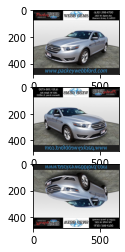

In [97]:
hoz_flip = image.transpose(Image.FLIP_LEFT_RIGHT)
# vertical flip
ver_flip = image.transpose(Image.FLIP_TOP_BOTTOM)
# plot all three images using matplotlib
pyplot.subplot(311)
pyplot.imshow(image)
pyplot.subplot(312)
pyplot.imshow(hoz_flip)
pyplot.subplot(313)
pyplot.imshow(ver_flip)
pyplot.show()

<i>In the above flip we can see in horizontal flip the angle of the image
changed completely that can make it fall into driver side to passenger side.
So while preprocessing we will not use horizontal flip parameter</i>

## Splitting Data

#### Splited the data using python split-folder package.
#### One time task to get the test, train and val split folder wise

In [4]:
## Split data 80% training, 10% Validation, 10% testing
import splitfolders
# path of image data set
input_folder = "data/"
# where you want the split datasets saved. one will be created if
# it does not exist or none is set
output = "splitted_data/" 
# ratio of split are in order of train/val/test. You can change to whatever you want.
# For train/test/val user ratio values as percentage i.e. .8 = 80%
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1)) 

Copying files: 4500 files [00:04, 1008.57 files/s]


## Define Generator

In [77]:
from keras.preprocessing.image import ImageDataGenerator
#Sometimes horizontal flip can change the angle of view of image and can cause driver side to passenger side
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)
                
training_set = train_datagen.flow_from_directory('splitted_data/train/',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('splitted_data/test',
                                            target_size = (64,64),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                           shuffle=False)

val_set = validation_datagen.flow_from_directory('splitted_data/val',
                                            target_size = (64,64),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                                shuffle=False)

Found 3600 images belonging to 9 classes.
Found 450 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


## Define Model

In [78]:
# Initialising the CNN
classifier = Sequential(name="Multiclassifier_Model")

# Step 1 - Convolution and Pooling Layers
# tried with 1 convolution layer and one max pooling layer with 
# 256*256 & 512*512 it worked but model train was very slow.
# later with little lesser pixel size 64*64 model training was fast but
# validation loss was too much and accuracy was 70% only.
# Added one extra conv2d and pool layer with higher feature detector
# of size 64 model accuracy increased a little but the val loss difference
# was still 10% so added one extra combination of conv2d and pool layer
# with higher feature detector to 128.

classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(128,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
 
# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
# Started with 128 neuron and 1 hidden layer but due to high val loss
# added one more hidden layer with 32 neuron and dropout of 20% it worked
# much better
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dense(9, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [4]:
classifier.summary()

Model: "Multiclassifier_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)    

## Compiling Model

In [79]:
# compiling our CNN model
# tested with different rmsprop optiizer but convergence was slow
# tested with learning rate 0.001, 0.002 default worked much better than custom learning rates
# default parameters worked much better.
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Training

In [80]:
history = classifier.fit_generator(training_set,
                         steps_per_epoch = len(training_set), # total images in our training set
                         epochs = 50, 
                         validation_data = test_set, # total images in our test data images
                                  verbose=1, # visualize full report of lossess every epoch
                                  workers=4)

Epoch 1/50
113/113 [==============================] - 18s 156ms/step - loss: 1.6435 - accuracy: 0.3894 - val_loss: 0.7498 - val_accuracy: 0.7356
Epoch 2/50
113/113 [==============================] - 18s 163ms/step - loss: 0.6951 - accuracy: 0.7617 - val_loss: 0.3481 - val_accuracy: 0.9022
Epoch 3/50
113/113 [==============================] - 21s 184ms/step - loss: 0.4868 - accuracy: 0.8350 - val_loss: 0.3869 - val_accuracy: 0.8867
Epoch 4/50
113/113 [==============================] - 18s 163ms/step - loss: 0.3496 - accuracy: 0.8883 - val_loss: 0.2251 - val_accuracy: 0.9267
Epoch 5/50
113/113 [==============================] - 18s 160ms/step - loss: 0.2835 - accuracy: 0.9117 - val_loss: 0.1755 - val_accuracy: 0.9400
Epoch 6/50
113/113 [==============================] - 19s 167ms/step - loss: 0.2478 - accuracy: 0.9181 - val_loss: 0.2356 - val_accuracy: 0.9244
Epoch 7/50
113/113 [==============================] - 20s 173ms/step - loss: 0.1877 - accuracy: 0.9386 - val_loss: 0.1353 - val_ac

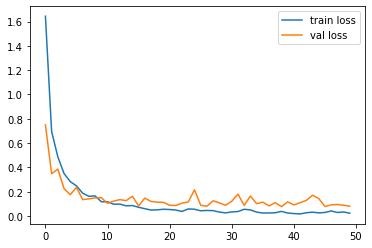

In [81]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='val loss')
pyplot.legend()
pyplot.show()

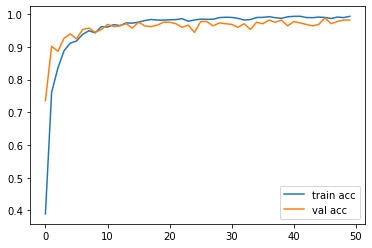

In [82]:
pyplot.plot(history.history['accuracy'], label='train acc')
pyplot.plot(history.history['val_accuracy'], label='val acc')
pyplot.legend()
pyplot.show()

## evaluating our model on validation data set

In [84]:
loss, accuracy = classifier.evaluate(val_set)

15/15 [==============================] - 4s 238ms/step - loss: 0.1204 - accuracy: 0.9733


In [86]:
print(f"Loss : {loss*100:2f} %")
print(f"Accuracy : {accuracy*100:2f} %")

Loss : 12.038641 %
Accuracy : 97.333336 %


# Evaluating the model on classification report and confusion matrix

In [88]:
Y_pred = classifier.predict_generator(test_set, test_set.samples // test_set.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = test_set.class_indices
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[50  0  0  0  0  0  0  0  0]
 [ 0 49  1  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0]
 [ 0  0  0 49  0  0  0  0  1]
 [ 0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  1  0 48  1]
 [ 0  0  0  0  1  0  0  3 46]]
Classification Report
                            precision    recall  f1-score   support

   3_4th_driver_side_front       1.00      1.00      1.00        50
    3_4th_driver_side_rear       1.00      0.98      0.99        50
3_4th_passenger_side_front       0.98      1.00      0.99        50
 3_4th_passenger_side_rear       1.00      0.98      0.99        50
               driver_side       0.98      1.00      0.99        50
                     front       0.98      1.00      0.99        50
            passenger_side       1.00      1.00      1.00        50
                      rear       0.94      0.96      0.95        50
                   unknown       0.96      0.92      0.94        50

        

## Testing

In [29]:
path = %pwd

In [30]:
path

'D:\\python_practice\\Sr.DS_Assgn\\Sr.DS Assgn'

In [128]:
# Here some of the test images can be taken from
# validation set(images that model has never seen)
# we can randomely choose image and pass as image name to test it
# that will give the classname from the set of data.
from keras.preprocessing import image

import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r'D:/python_practice/Sr.DS_Assgn/Sr.DS Assgn/190508.jpg', target_size = (64,64))
test_image.show()
test_image = np.expand_dims(test_image, axis=0)
result = classifier.predict(test_image)
# print(result[0][])
if result[0][0] == 1:
    prediction = '3_4th_driver_side_front'
elif result[0][1] == 1:
    prediction = '3_4th_driver_side_rear'
elif result[0][2] == 1:
    prediction = '3_4th_passenger_side_front'
elif result[0][3] == 1:
    prediction = '3_4th_passenger_side_rear'
elif result[0][4] == 1:
    prediction = 'driver_side'
elif result[0][5] == 1:
    prediction = 'front'
elif result[0][6] == 1:
    prediction = 'passenger_side'
elif result[0][7] == 1:
    prediction = 'rear'
elif result[0][8] == 1:
    prediction = 'unknown'
print(prediction)

driver_side


## Improving Model

<b>I tried to work with pretrained model Like vgg16 and vgg19 and it
turned out vgg19 worked little better than than vgg16</b>

In [50]:
# Data Preparation steps remains the same only we will take VGG19 model, 
# there is no need to train its weight we will keep it intact.
# We will add only the last layer in this model, we that we can predict
# the classes depending upon the use case

In [103]:
from keras.applications.vgg19 import VGG19
from glob import glob
from keras.models import Model

In [104]:
vgg = VGG19(input_shape=[64,64]+[3], weights='imagenet', include_top=False)

In [105]:
for layer in vgg.layers:
    layer.trainable = False

In [106]:
folder = glob('splitted_data/train/*')

In [107]:
folder

['splitted_data/train\\3_4th_driver_side_front',
 'splitted_data/train\\3_4th_driver_side_rear',
 'splitted_data/train\\3_4th_passenger_side_front',
 'splitted_data/train\\3_4th_passenger_side_rear',
 'splitted_data/train\\driver_side',
 'splitted_data/train\\front',
 'splitted_data/train\\passenger_side',
 'splitted_data/train\\rear',
 'splitted_data/train\\unknown']

In [108]:
x = Flatten()(vgg.output)

In [109]:
# adding the last layer into the model
prediction = Dense(len(folder), activation='softmax')(x)

In [110]:
model = Model(inputs=vgg.input, outputs=prediction, name='VGG19_based_Multiclassifier')

In [111]:
model.summary()

Model: "VGG19_based_Multiclassifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16,

In [112]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [113]:
vgg_history = model.fit_generator(training_set,
                       validation_data=test_set,
                       epochs=15,
                       steps_per_epoch=len(training_set),
                       validation_steps=len(test_set),
                       workers=4,
                       verbose=1)

Epoch 1/15
113/113 [==============================] - 63s 561ms/step - loss: 1.4699 - accuracy: 0.4983 - val_loss: 1.1075 - val_accuracy: 0.6311
Epoch 2/15
113/113 [==============================] - 60s 530ms/step - loss: 0.9559 - accuracy: 0.6933 - val_loss: 0.8724 - val_accuracy: 0.6978
Epoch 3/15
113/113 [==============================] - 55s 485ms/step - loss: 0.7929 - accuracy: 0.7436 - val_loss: 0.7844 - val_accuracy: 0.7378
Epoch 4/15
113/113 [==============================] - 55s 483ms/step - loss: 0.6979 - accuracy: 0.7794 - val_loss: 0.7126 - val_accuracy: 0.7644
Epoch 5/15
113/113 [==============================] - 55s 485ms/step - loss: 0.6468 - accuracy: 0.7964 - val_loss: 0.6379 - val_accuracy: 0.7956
Epoch 6/15
113/113 [==============================] - 55s 490ms/step - loss: 0.5873 - accuracy: 0.8072 - val_loss: 0.6438 - val_accuracy: 0.7644
Epoch 7/15
113/113 [==============================] - 55s 486ms/step - loss: 0.5478 - accuracy: 0.8294 - val_loss: 0.6105 - val_ac

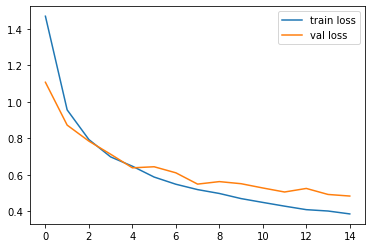

In [114]:
pyplot.plot(vgg_history.history['loss'], label='train loss')
pyplot.plot(vgg_history.history['val_loss'], label='val loss')
pyplot.legend()
pyplot.show()

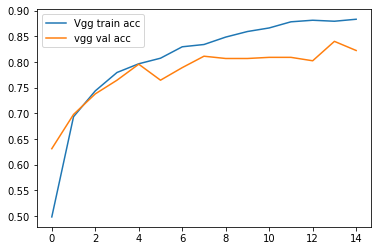

In [115]:
pyplot.plot(vgg_history.history['accuracy'], label='Vgg train acc')
pyplot.plot(vgg_history.history['val_accuracy'], label='vgg val acc')
pyplot.legend()
pyplot.show()

## Testing out VGG 19 model

In [129]:
# Here some of the test images can be taken from
# validation set(images that model has never seen)
# we can randomely choose image and pass as image name to test it
# that will give the classname from the set of data.
from keras.preprocessing import image

import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r'D:/python_practice/Sr.DS_Assgn/Sr.DS Assgn/190508.jpg', target_size = (64,64))
test_image.show()
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
# print(result[0][])
if result[0][0] == 1:
    prediction = '3_4th_driver_side_front'
elif result[0][1] == 1:
    prediction = '3_4th_driver_side_rear'
elif result[0][2] == 1:
    prediction = '3_4th_passenger_side_front'
elif result[0][3] == 1:
    prediction = '3_4th_passenger_side_rear'
elif result[0][4] == 1:
    prediction = 'driver_side'
elif result[0][5] == 1:
    prediction = 'front'
elif result[0][6] == 1:
    prediction = 'passenger_side'
elif result[0][7] == 1:
    prediction = 'rear'
elif result[0][8] == 1:
    prediction = 'unknown'
print(prediction)

driver_side


In [66]:
# visualizing both the cnn model and vgg19 model performances loss in 1 chart

# Comparing our CNN model with VGG19 model

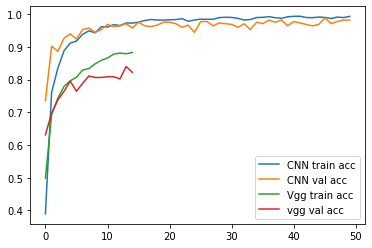

In [125]:
pyplot.plot(history.history['accuracy'], label='CNN train acc')
pyplot.plot(history.history['val_accuracy'], label='CNN val acc')
pyplot.plot(vgg_history.history['accuracy'], label='Vgg train acc')
pyplot.plot(vgg_history.history['val_accuracy'], label='vgg val acc')
pyplot.legend()
pyplot.show()

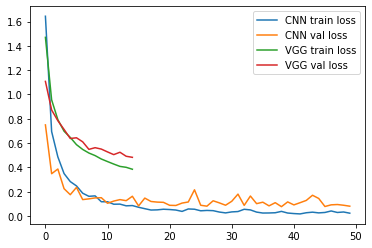

In [126]:
pyplot.plot(history.history['loss'], label='CNN train loss')
pyplot.plot(history.history['val_loss'], label='CNN val loss')
pyplot.plot(vgg_history.history['loss'], label='VGG train loss')
pyplot.plot(vgg_history.history['val_loss'], label='VGG val loss')
pyplot.legend()
pyplot.show()

## Analysing classification report and confusion matrix
## for our classification model based on VGG19

In [120]:
Y_pred = model.predict_generator(test_set, test_set.samples // test_set.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = test_set.class_indices
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[44  0  0  0  0  6  0  0  0]
 [ 0 41  3  0  1  2  0  2  1]
 [ 1  8 39  0  1  1  0  0  0]
 [ 5  2  0 35  3  2  0  1  2]
 [ 0  1  0  0 47  0  2  0  0]
 [ 0  0  0  2  0 40  0  8  0]
 [ 0  1  0  0 16  0 31  0  2]
 [ 0  1  0  0  1  2  1 45  0]
 [ 0  0  0  0  0  1  0  1 48]]
Classification Report
                            precision    recall  f1-score   support

   3_4th_driver_side_front       0.88      0.88      0.88        50
    3_4th_driver_side_rear       0.76      0.82      0.79        50
3_4th_passenger_side_front       0.93      0.78      0.85        50
 3_4th_passenger_side_rear       0.95      0.70      0.80        50
               driver_side       0.68      0.94      0.79        50
                     front       0.74      0.80      0.77        50
            passenger_side       0.91      0.62      0.74        50
                      rear       0.79      0.90      0.84        50
                   unknown       0.91      0.96      0.93        50

        